### Import

In [6]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
import matplotlib.pyplot as plt

### Load Dataset

In [8]:
# Define your parameters here
batch_size = 32
img_height = 256
img_width = 256

# Use the correct local or mounted path
directory_train = 'C:/Users/admin/Desktop/Project/Dataset/Training'

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    directory_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)

Found 5712 files belonging to 4 classes.


In [9]:
# Define your parameters here
batch_size = 32
img_height = 256
img_width = 256

# Use the correct local or mounted path
directory_test = 'C:/Users/admin/Desktop/Project/Dataset/Testing'

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    directory_test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=123,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)

Found 1311 files belonging to 4 classes.


In [10]:
import matplotlib.pyplot as plt

def show_batch(dataset, num_images=9):
    """
    Displays a batch of images from the dataset.

    Parameters:
    - dataset: The dataset from which to show images.
    - num_images: The number of images to display.

    """
    print(dataset.take(1))
    # Extract a batch of 'num_images' from the dataset
    for images, labels in dataset.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            ax = plt.subplot(int(num_images**0.5), int(num_images**0.5), i + 1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
            plt.title(int(labels[i]))
            plt.axis("off")

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


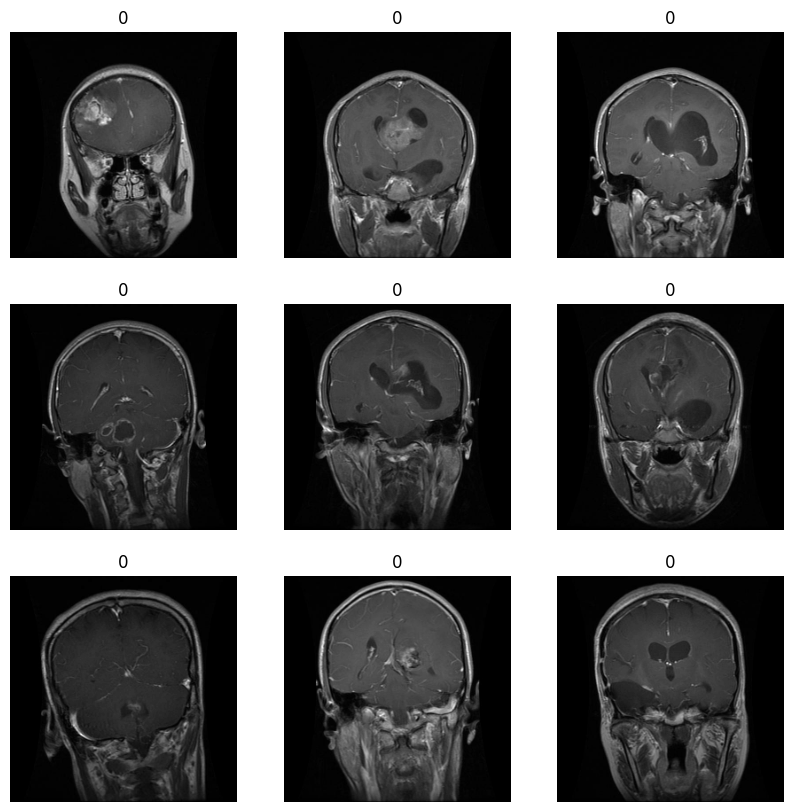

In [11]:
show_batch(ds_train)

### Data About Loaded Dataset

In [12]:
print(ds_test.class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [13]:
import os

def count_images_in_each_label(directory):
    # Initialize a dictionary to hold the count of images per label
    label_counts = {}
    
    # List all items in the directory
    for label in os.listdir(directory):
        # Construct the path to the label's directory
        label_dir = os.path.join(directory, label)
        
        # Check if the path is indeed a directory
        if os.path.isdir(label_dir):
            # Count the number of image files in the directory
            num_images = len([name for name in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, name))])
            label_counts[label] = num_images
            
    return label_counts

In [14]:
# Use the correct local or mounted path
directory_test = 'C:/Users/admin/Desktop/Project/Dataset/Training'

# Get the count of images in each label
label_counts = count_images_in_each_label(directory_test)

# Print the counts
for label, count in label_counts.items():
    print(f"Label: {label}, Number of Images: {count}")

Label: glioma, Number of Images: 1321
Label: meningioma, Number of Images: 1339
Label: notumor, Number of Images: 1595
Label: pituitary, Number of Images: 1457


In [15]:
# Use the correct local or mounted path
directory_test = 'C:/Users/admin/Desktop/Project/Dataset/Testing'

# Get the count of images in each label
label_counts = count_images_in_each_label(directory_test)

# Print the counts
for label, count in label_counts.items():
    print(f"Label: {label}, Number of Images: {count}")

Label: glioma, Number of Images: 300
Label: meningioma, Number of Images: 306
Label: notumor, Number of Images: 405
Label: pituitary, Number of Images: 300


### Median Filter

In [16]:
import tensorflow as tf
from typing import Optional, Union, List, Tuple, Iterable
import numpy as np


Number = Union[
    float,
    int,
    np.float16,
    np.float32,
    np.float64,
    np.int8,
    np.int16,
    np.int32,
    np.int64,
    np.uint8,
    np.uint16,
    np.uint32,
    np.uint64,
]

TensorLike = Union[
    List[Union[Number, list]],
    tuple,
    Number,
    np.ndarray,
    tf.Tensor,
    tf.SparseTensor,
    tf.Variable
]

def apply_median_filter(image, label):
    """
    Apply a median filter to an image.

    Args:
    - image: A tensor representing an image.
    - label: The corresponding label for the image.

    Returns:
    - filtered_image: The image after applying the median filter.
    - label: The unchanged label.
    """
    # Apply the median filter. The `filter_shape` parameter determines the size of the
    # window over which the median is computed. A larger value will lead to more smoothing.
    # Here, we use a 3x3 window as an example.
    filtered_image = median_filter2d(image, filter_shape=(3, 3))

    return filtered_image, label

# Assuming your dataset is named `ds_train`
# Apply the median filter to each image in the dataset
# ds_train_filtered = ds_train.map(apply_median_filter)

def get_ndims(image):
    return image.get_shape().ndims or tf.rank(image)


def to_4D_image(image):
    """Convert 2/3/4D image to 4D image.

    Args:
      image: 2/3/4D `Tensor`.

    Returns:
      4D `Tensor` with the same type.
    """
    with tf.control_dependencies(
        [
            tf.debugging.assert_rank_in(
                image, [2, 3, 4], message="`image` must be 2/3/4D tensor"
            )
        ]
    ):
        ndims = image.get_shape().ndims
        if ndims is None:
            return _dynamic_to_4D_image(image)
        elif ndims == 2:
            return image[None, :, :, None]
        elif ndims == 3:
            return image[None, :, :, :]
        else:
            return image

def _dynamic_to_4D_image(image):
    shape = tf.shape(image)
    original_rank = tf.rank(image)
    # 4D image => [N, H, W, C] or [N, C, H, W]
    # 3D image => [1, H, W, C] or [1, C, H, W]
    # 2D image => [1, H, W, 1]
    left_pad = tf.cast(tf.less_equal(original_rank, 3), dtype=tf.int32)
    right_pad = tf.cast(tf.equal(original_rank, 2), dtype=tf.int32)
    new_shape = tf.concat(
        [
            tf.ones(shape=left_pad, dtype=tf.int32),
            shape,
            tf.ones(shape=right_pad, dtype=tf.int32),
        ],
        axis=0,
    )
    return tf.reshape(image, new_shape)

def _dynamic_from_4D_image(image, original_rank):
    shape = tf.shape(image)
    # 4D image <= [N, H, W, C] or [N, C, H, W]
    # 3D image <= [1, H, W, C] or [1, C, H, W]
    # 2D image <= [1, H, W, 1]
    begin = tf.cast(tf.less_equal(original_rank, 3), dtype=tf.int32)
    end = 4 - tf.cast(tf.equal(original_rank, 2), dtype=tf.int32)
    new_shape = shape[begin:end]
    return tf.reshape(image, new_shape)

def from_4D_image(image, ndims):
    """Convert back to an image with `ndims` rank.

    Args:
      image: 4D `Tensor`.
      ndims: The original rank of the image.

    Returns:
      `ndims`-D `Tensor` with the same type.
    """
    with tf.control_dependencies(
        [tf.debugging.assert_rank(image, 4, message="`image` must be 4D tensor")]
    ):
        if isinstance(ndims, tf.Tensor):
            return _dynamic_from_4D_image(image, ndims)
        elif ndims == 2:
            return tf.squeeze(image, [0, 3])
        elif ndims == 3:
            return tf.squeeze(image, [0])
        else:
            return image

@tf.function
def median_filter2d(
    image: TensorLike,
    filter_shape: Union[int, Iterable[int]] = (3, 3),
    padding: str = "REFLECT",
    constant_values: TensorLike = 0,
    name: Optional[str] = None,
) -> tf.Tensor:
    """Perform median filtering on image(s).

    Args:
      image: Either a 2-D `Tensor` of shape `[height, width]`,
        a 3-D `Tensor` of shape `[height, width, channels]`,
        or a 4-D `Tensor` of shape `[batch_size, height, width, channels]`.
      filter_shape: An `integer` or `tuple`/`list` of 2 integers, specifying
        the height and width of the 2-D median filter. Can be a single integer
        to specify the same value for all spatial dimensions.
      padding: A `string`, one of "REFLECT", "CONSTANT", or "SYMMETRIC".
        The type of padding algorithm to use, which is compatible with
        `mode` argument in `tf.pad`. For more details, please refer to
        https://www.tensorflow.org/api_docs/python/tf/pad.
      constant_values: A `scalar`, the pad value to use in "CONSTANT"
        padding mode.
      name: A name for this operation (optional).
    Returns:
      2-D, 3-D or 4-D `Tensor` of the same dtype as input.
    Raises:
      ValueError: If `image` is not 2, 3 or 4-dimensional,
        if `padding` is other than "REFLECT", "CONSTANT" or "SYMMETRIC",
        or if `filter_shape` is invalid.
    """
    with tf.name_scope(name or "median_filter2d"):
        image = tf.convert_to_tensor(image, name="image")
        original_ndims = get_ndims(image)
        image = to_4D_image(image)

        filter_shape = normalize_tuple(filter_shape, 2, "filter_shape")

        image_shape = tf.shape(image)
        batch_size = image_shape[0]
        height = image_shape[1]
        width = image_shape[2]
        channels = image_shape[3]

        # Explicitly pad the image
        image = _pad(image, filter_shape, mode=padding, constant_values=constant_values)

        area = filter_shape[0] * filter_shape[1]

        floor = (area + 1) // 2
        ceil = area // 2 + 1

        patches = tf.image.extract_patches(
            image,
            sizes=[1, filter_shape[0], filter_shape[1], 1],
            strides=[1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        patches = tf.reshape(patches, shape=[batch_size, height, width, area, channels])

        patches = tf.transpose(patches, [0, 1, 2, 4, 3])

        # Note the returned median is casted back to the original type
        # Take [5, 6, 7, 8] for example, the median is (6 + 7) / 2 = 3.5
        # It turns out to be int(6.5) = 6 if the original type is int
        top = tf.nn.top_k(patches, k=ceil).values
        if area % 2 == 1:
            median = top[:, :, :, :, floor - 1]
        else:
            median = (top[:, :, :, :, floor - 1] + top[:, :, :, :, ceil - 1]) / 2

        output = tf.cast(median, image.dtype)
        output = from_4D_image(output, original_ndims)
        return output

def normalize_tuple(value, n, name):
    """Transforms an integer or iterable of integers into an integer tuple.

    A copy of tensorflow.python.keras.util.

    Args:
      value: The value to validate and convert. Could an int, or any iterable
        of ints.
      n: The size of the tuple to be returned.
      name: The name of the argument being validated, e.g. "strides" or
        "kernel_size". This is only used to format error messages.

    Returns:
      A tuple of n integers.

    Raises:
      ValueError: If something else than an int/long or iterable thereof was
        passed.
    """
    if isinstance(value, int):
        return (value,) * n
    else:
        try:
            value_tuple = tuple(value)
        except TypeError:
            raise TypeError(
                "The `"
                + name
                + "` argument must be a tuple of "
                + str(n)
                + " integers. Received: "
                + str(value)
            )
        if len(value_tuple) != n:
            raise ValueError(
                "The `"
                + name
                + "` argument must be a tuple of "
                + str(n)
                + " integers. Received: "
                + str(value)
            )
        for single_value in value_tuple:
            try:
                int(single_value)
            except (ValueError, TypeError):
                raise ValueError(
                    "The `"
                    + name
                    + "` argument must be a tuple of "
                    + str(n)
                    + " integers. Received: "
                    + str(value)
                    + " "
                    "including element "
                    + str(single_value)
                    + " of type"
                    + " "
                    + str(type(single_value))
                )
        return value_tuple


def _pad(
    image: TensorLike,
    filter_shape: Union[List[int], Tuple[int]],
    mode: str = "CONSTANT",
    constant_values: TensorLike = 0,
) -> tf.Tensor:
    """Explicitly pad a 4-D image.

    Equivalent to the implicit padding method offered in `tf.nn.conv2d` and
    `tf.nn.depthwise_conv2d`, but supports non-zero, reflect and symmetric
    padding mode. For the even-sized filter, it pads one more value to the
    right or the bottom side.

    Args:
      image: A 4-D `Tensor` of shape `[batch_size, height, width, channels]`.
      filter_shape: A `tuple`/`list` of 2 integers, specifying the height
        and width of the 2-D filter.
      mode: A `string`, one of "REFLECT", "CONSTANT", or "SYMMETRIC".
        The type of padding algorithm to use, which is compatible with
        `mode` argument in `tf.pad`. For more details, please refer to
        https://www.tensorflow.org/api_docs/python/tf/pad.
      constant_values: A `scalar`, the pad value to use in "CONSTANT"
        padding mode.
    """
    if mode.upper() not in {"REFLECT", "CONSTANT", "SYMMETRIC"}:
        raise ValueError(
            'padding should be one of "REFLECT", "CONSTANT", or "SYMMETRIC".'
        )
    constant_values = tf.convert_to_tensor(constant_values, image.dtype)
    filter_height, filter_width = filter_shape
    pad_top = (filter_height - 1) // 2
    pad_bottom = filter_height - 1 - pad_top
    pad_left = (filter_width - 1) // 2
    pad_right = filter_width - 1 - pad_left
    paddings = [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]]
    return tf.pad(image, paddings, mode=mode, constant_values=constant_values)

In [17]:
ds_train_processed = ds_train.map(apply_median_filter)

In [18]:
ds_test_processed = ds_test.map(apply_median_filter)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


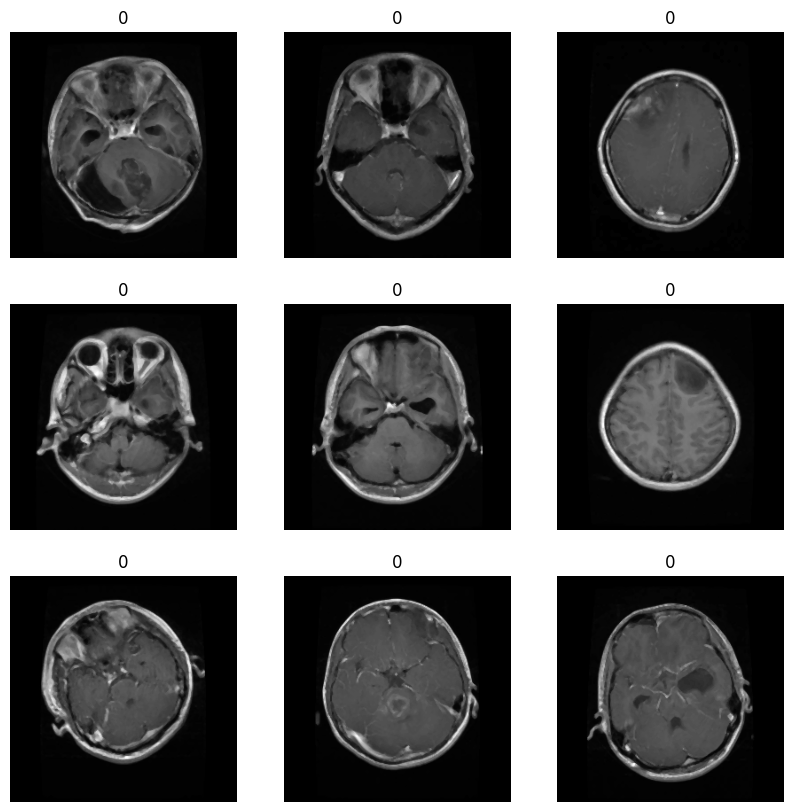

In [19]:
show_batch(ds_test_processed, num_images=9)

In [20]:
# i = 0
# j=0
# for images, labels in ds_test_processed.take(1):
for feature_batch, label_batch in ds_test_processed.take(1):
    # j = j+1
    print("batch", label_batch)
    print((feature_batch))
    # i = i + len(labels.numpy())
    # print("Class names:", ds_train.class_names)

batch tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...



In [21]:
len(ds_train_processed)

179

In [22]:
ds_test_processed

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
for images, labels in ds_test_processed.take(-1):
    print("Labels:", labels.numpy())
    print("Class names:", ds_train.class_names)

Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

### Image Segmentation

In [24]:
import tensorflow as tf

def segment_image(image, label):
    """
    Apply simple thresholding to segment the image.
    
    Ar
    gs:
    - image: The input image tensor.
    - label: The corresponding label tensor.
    
    Returns:
    - segmented_image: The segmented image tensor.
    - label: The unchanged label tensor.
    """
    # Convert the image to grayscale if it's not already
    image_gray = tf.image.rgb_to_grayscale(image) if image.shape[-1] == 3 else image
    
    # Normalize the image tensor to [0, 1]
    image_normalized = image_gray / 255.0
    
    # Define the threshold value
    threshold = 0.5  # This is a normalized threshold since the image is normalized
    
    # Apply thresholding
    segmented_image = tf.where(image_normalized < threshold, 0.0, 1.0)
    
    # The output segmented_image will have values 0 for background and 1 for foreground
    
    return segmented_image, label

In [25]:

# Assume ds is your TensorFlow dataset that has images and labels
ds_test_segmented = ds_test.map(segment_image)
ds_train_segmented = ds_train.map(segment_image)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


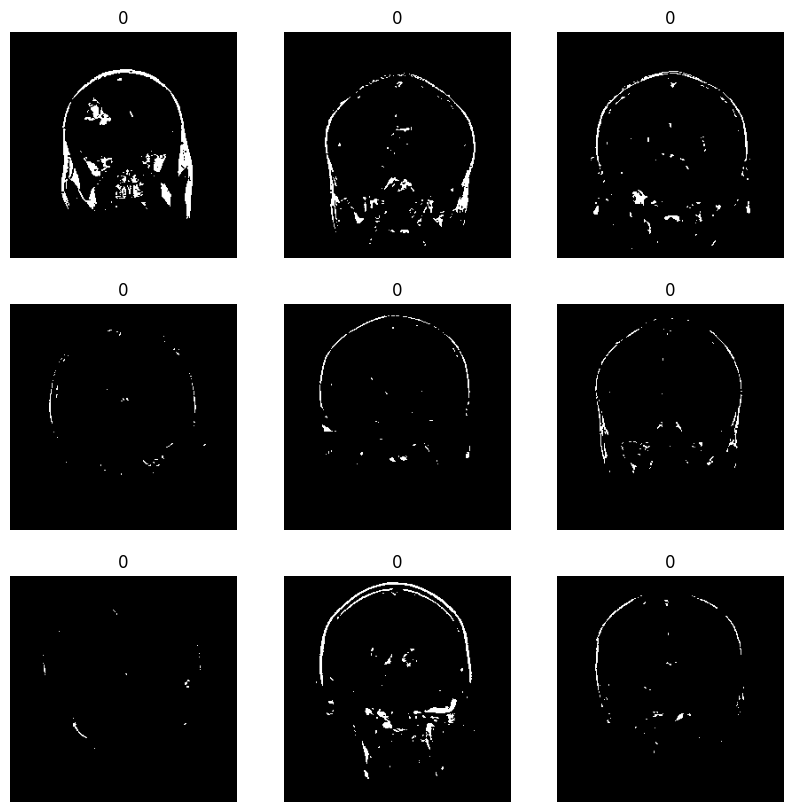

In [26]:
show_batch(ds_train_segmented, num_images=9)

# DWT

In [27]:
import pywt
import numpy as np
import tensorflow as tf

In [28]:
def apply_dwt_single(image):
    # Ensure image is 2D by removing the last dimension if it's 1
    if image.shape[-1] == 1:
        image = tf.squeeze(image, axis=-1)

    # print(type(image))
    # print(image.shape)
    # Convert the tensor to a numpy array for pywt
    # image_np = image.numpy()

    # coeffs = pywt.dwt2(image_np, 'haar')
    coeffs = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs
    return LL

def apply_dwt_thrice(image):
    for i in range(3):
        image = apply_dwt_single(image)
    # After processing, add back the channel dimension
    image = np.expand_dims(image, axis=-1)
    return image

# Image will be tensor given by a tf.dataset
def dwt_applier(image, label):
    print(image)
    print(label)
    # Ensure operations are done outside TensorFlow's graph to use numpy and pywt
    image_dwt = tf.py_function(func=apply_dwt_thrice, inp=[image], Tout=tf.float64)

    # Ensure the output tensor has the right shape and type
    # image_dwt.set_shape((None, None, 1))  # We know the final channel dimension, but not spatial dimensions
    return image_dwt, label



In [29]:
ds_train_dwt = ds_train_segmented.map(dwt_applier)
ds_test_dwt = ds_test_segmented.map(dwt_applier)

Tensor("args_0:0", shape=(None, 256, 256, 1), dtype=float32)
Tensor("args_1:0", shape=(None,), dtype=int32)
Tensor("args_0:0", shape=(None, 256, 256, 1), dtype=float32)
Tensor("args_1:0", shape=(None,), dtype=int32)


In [30]:
print(len(ds_train))

179


In [31]:
print(len(ds_train_processed))

179


In [32]:
print(len(ds_train_segmented))

179


In [33]:
print(len(ds_train_dwt))

179


<_TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


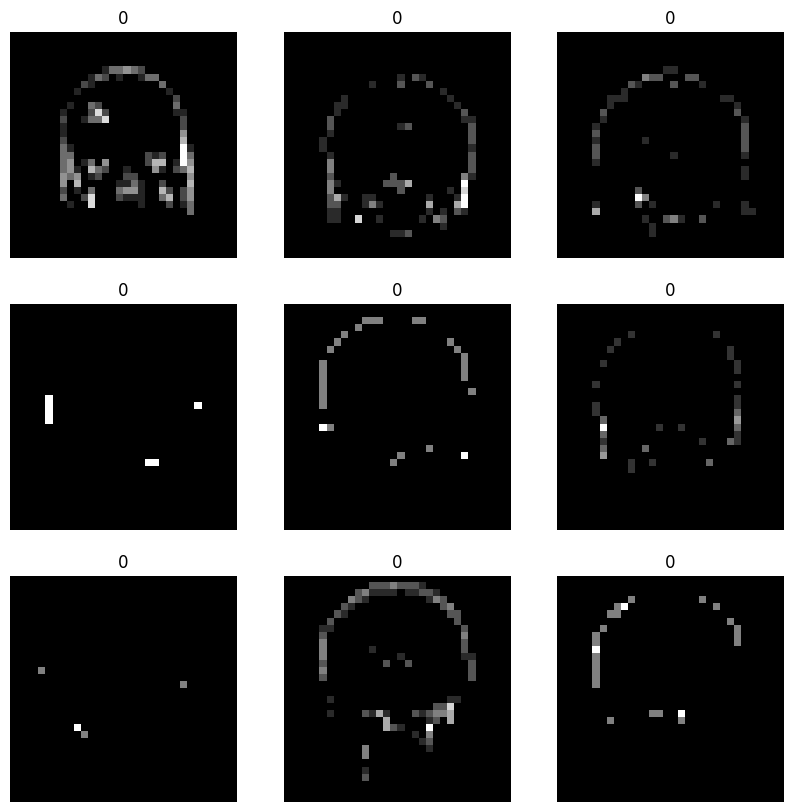

In [34]:
show_batch(ds_train_dwt, num_images=9)

In [36]:
ds_train_dwt.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
type(ds_train_dwt)

tensorflow.python.data.ops.map_op._MapDataset

In [47]:
# i = 0
# j=0
# for images, labels in ds_test_processed.take(1):
for feature_batch, label_batch in ds_train_dwt.take(1):
    print("batch", label_batch)
    print((feature_batch[31]))
    print(type(feature_batch[0]))

batch tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(32, 32, 1), dtype=float64)
<class 'tensorflow.python.framework.ops.EagerTensor'>


### PCA

In [59]:
ds_train_flat = ds_train_dwt.map(lambda features, label: (tf.reshape(features, [-1]), label))

In [60]:
def dataset_to_numpy(ds):
    features_list, labels_list = [], []
    for features, label in ds:
        features_list.append(features.numpy())
        labels_list.append(label.numpy())
    # Stack the list of features and convert labels list to a numpy array
    features_np = np.vstack(features_list)
    labels_np = np.array(labels_list)
    return features_np, labels_np

In [61]:
from sklearn.decomposition import PCA

# Assuming ds_train_flat is your flattened dataset
features, labels = dataset_to_numpy(ds_train_flat)

# Initialize PCA to reduce the features to 13 components
pca = PCA(n_components=13)

# Fit and transform the features
features_pca = pca.fit_transform(features)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 32768 and the array at index 178 has size 16384

In [ ]:
ds_train_pca = tf.data.Dataset.from_tensor_slices((features_pca, labels))

# Apply batching as needed
batch_size = 32
ds_train_pca = ds_train_pca.batch(batch_size)


In [62]:
import tensorflow as tf
import numpy as np

def dataset_to_numpy(ds, expected_size=None):
    features_list, labels_list = [], []
    for features, label in ds.unbatch():  # Unbatch to process images individually
        if expected_size:
            # Flatten and resize if there's an expected size, otherwise just flatten
            flat_feature = tf.reshape(features, [-1])[:expected_size]
        else:
            flat_feature = tf.reshape(features, [-1])
        features_list.append(flat_feature.numpy())
        labels_list.append(label.numpy())

    # Ensure all features have the expected size
    if expected_size:
        features_np = np.array([f[:expected_size] for f in features_list])
    else:
        features_np = np.vstack(features_list)

    labels_np = np.array(labels_list)
    return features_np, labels_np

# Determine the flattened size of your images (for 256x256x1 images, this would be 65536)
flattened_size = 256 * 256



In [70]:
# Convert dataset to numpy, ensuring all feature vectors are of the same size
features_train, labels_train = dataset_to_numpy(ds_train_dwt, expected_size=flattened_size)

In [71]:
features_test, labels_test = dataset_to_numpy(ds_test_dwt, expected_size=flattened_size)

In [72]:
features_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [73]:
from sklearn.decomposition import PCA

# Initialize PCA to reduce the features to 13 components
pca = PCA(n_components=13)

In [75]:
# Fit and transform the features
features_pca_train = pca.fit_transform(features_train)
features_pca_test = pca.fit_transform(features_test)

In [76]:
ds_train_pca = tf.data.Dataset.from_tensor_slices((features_pca_train, labels_train))
ds_test_pca = tf.data.Dataset.from_tensor_slices((features_pca_test, labels_test))

In [78]:
# # Apply batching as needed
batch_size = 32
ds_train_pca = ds_train_pca.batch(batch_size)
ds_test_pca = ds_test_pca.batch(batch_size)

# Dataset to Numpy

In [101]:
import numpy as np

def dataset_to_numpy(ds):
    features, labels = [], []
    for feature_batch, label_batch in ds:
        features.extend(feature_batch.numpy())
        labels.extend(label_batch.numpy())
    return np.array(features), np.array(labels)

X_train, y_train = dataset_to_numpy(ds_train_dwt)
X_test, y_test = dataset_to_numpy(ds_test_dwt)

In [102]:
type(X_train[0])

numpy.ndarray

# ANN

In [103]:
img_height = None
img_width = 32

In [105]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD

def create_mlp_model(input_shape, hidden_layers, output_units, learning_rate=0.3, momentum=0.2):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten the input
    for units in hidden_layers:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(output_units, activation='softmax'))  # Output layer
    
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [107]:
tf.random.set_seed(0)  # Set seed

img_height = 32
img_width = 32

# Assuming your input data is of shape (img_height, img_width, channels)
# Adjust this according to your actual data shape
input_shape = (img_height, img_width, 1)  
hidden_layers = [64, 64]  
output_units = len(ds_train.class_names) 


In [113]:
model = create_mlp_model(input_shape, hidden_layers, output_units, learning_rate=0.3, momentum=0.2)

In [108]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

In [109]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=100, callbacks=[early_stopping], verbose=1)

Epoch 1/100
58/58 [==============================] - 1s 7ms/step - loss: 3.8936 - accuracy: 0.4076 - val_loss: 1.2764 - val_accuracy: 0.4546
Epoch 2/100
58/58 [==============================] - 0s 3ms/step - loss: 1.0474 - accuracy: 0.5364 - val_loss: 1.1052 - val_accuracy: 0.5080
Epoch 3/100
58/58 [==============================] - 0s 4ms/step - loss: 0.8149 - accuracy: 0.6527 - val_loss: 0.9148 - val_accuracy: 0.5912
Epoch 4/100
58/58 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.7211 - val_loss: 1.0219 - val_accuracy: 0.6895
Epoch 5/100
58/58 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.7358 - val_loss: 0.8275 - val_accuracy: 0.7132
Epoch 6/100
58/58 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.7498 - val_loss: 0.7139 - val_accuracy: 0.7277
Epoch 7/100
58/58 [==============================] - 0s 4ms/step - loss: 0.6379 - accuracy: 0.7505 - val_loss: 1.3974 - val_accuracy: 0.5484
Epoch 8/100
5

In [110]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

41/41 - 0s - loss: 0.6262 - accuracy: 0.8383 - 65ms/epoch - 2ms/step
Test accuracy: 0.8382914066314697, Test loss: 0.6262142062187195


KNN

In [114]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


In [115]:
# Normalize the data to [0, 1]
X_train_flat = X_train_flat.astype('float32') / 255.
X_test_flat = X_test_flat.astype('float32') / 255.


In [116]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # Example: using 5 neighbors

# Train the KNN model
knn.fit(X_train_flat, y_train)

KNeighborsClassifier()

In [117]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions
y_pred = knn.predict(X_test_flat)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Additional metrics
print(classification_report(y_test, y_pred))


Accuracy: 0.8306636155606407
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       300
           1       0.87      0.51      0.65       306
           2       0.84      0.94      0.89       405
           3       0.90      0.92      0.91       300

    accuracy                           0.83      1311
   macro avg       0.84      0.82      0.82      1311
weighted avg       0.84      0.83      0.82      1311



SVM

In [119]:
# Assuming X_train and X_test are your datasets with images of shape (img_height, img_width, channels)
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], -1) / 255.0


In [120]:
from sklearn.svm import SVC

# Initialize the SVM model
svm = SVC(kernel='rbf', C=1.0, gamma='scale')  # Default settings; adjust as necessary

# Train the SVM model
svm.fit(X_train_flat, y_train)


SVC()

In [121]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions
y_pred = svm.predict(X_test_flat)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Additional metrics
print(classification_report(y_test, y_pred, target_names=ds_train.class_names))


Accuracy: 0.8611746758199847
              precision    recall  f1-score   support

      glioma       0.75      0.82      0.78       300
  meningioma       0.81      0.78      0.80       306
     notumor       0.98      0.90      0.94       405
   pituitary       0.89      0.93      0.91       300

    accuracy                           0.86      1311
   macro avg       0.86      0.86      0.86      1311
weighted avg       0.87      0.86      0.86      1311

